In [27]:
import pickle 
with open('/sietch_colab/akapoor/Demographic_Inference/split_isolation_model_seed_42/sims/sims_pretrain_20_sims_inference_1_seed_42_num_replicates_2_top_values_1/simulation_results/software_inferences_sim_0.pkl', 'rb') as f:
    software_inf_0 = pickle.load(f)

In [28]:
software_inf_0.keys()

dict_keys(['simulated_params', 'sfs', 'model_sfs_moments', 'opt_theta_moments', 'opt_params_moments', 'll_all_replicates_moments', 'opt_params_momentsLD', 'll_all_replicates_momentsLD'])

In [29]:
software_inf_0['opt_params_moments']

[{'Na': 14647.263163819067,
  'N1': 220.44436949177117,
  'N2': 11447.979197448301,
  't_split': 1284.1001672388359,
  'm': 267.53826508165463}]

In [30]:
software_inf_0['simulated_params']

{'t_split': 753, 'N1': 381, 'N2': 6214, 'Na': 15441, 'm': 0}

In [31]:
software_inf_0['opt_params_momentsLD']

[{'N1': 378.9628435128196,
  'N2': 6112.499524461679,
  't_split': 729.8327979756792,
  'm': 5.982285028854961e-06,
  'Na': 15429.015504446295}]

In [32]:
import pandas as pd
import pickle
import json

# Assuming you have a list of file paths for the pickle files
software_inferences_file_list = [f'/sietch_colab/akapoor/Demographic_Inference/split_isolation_model_seed_42/sims/sims_pretrain_20_sims_inference_1_seed_42_num_replicates_2_top_values_1/simulation_results/software_inferences_sim_{i}.pkl' for i in range(20)]

# Load the experiment configuration from the JSON file
with open('/sietch_colab/akapoor/Demographic_Inference/experiment_config.json', 'r') as config_file:
    experiment_config = json.load(config_file)

# Initialize empty lists to store the rows for both data and target parameters
data = []
targets = []

# Loop over each pickle file
for file in software_inferences_file_list:
    with open(file, 'rb') as f:
        software_inf = pickle.load(f)

        # Initialize a dictionary for this row (for opt_params)
        row = {}

        # Extracting parameters based on enabled analyses in the config file
        # "Connect" to dadi_analysis if it's set to True in the config
        if experiment_config['dadi_analysis']:
            for params_dict in software_inf.get('opt_params_dadi', []):
                row.update({f'opt_params_dadi_{key}': value for key, value in params_dict.items()})

        # "Connect" to moments_analysis if it's set to True in the config
        if experiment_config['moments_analysis']:
            for params_dict in software_inf.get('opt_params_moments', []):
                row.update({f'opt_params_moments_{key}': value for key, value in params_dict.items()})

        # "Connect" to momentsLD_analysis if it's set to True in the config
        if experiment_config['momentsLD_analysis']:
            for params_dict in software_inf.get('opt_params_momentsLD', []):
                row.update({f'opt_params_momentsLD_{key}': value for key, value in params_dict.items()})

        # Add the parameter row to the data list
        data.append(row)

        # Extract the simulated_params (targets)
        simulated_params = software_inf.get('simulated_params', {})
        target_row = {f'simulated_params_{key}': value for key, value in simulated_params.items()}

        # Add the target row to the targets list
        targets.append(target_row)

# Create DataFrames from the data lists
df = pd.DataFrame(data)
targets_df = pd.DataFrame(targets)

In [33]:
df.head()

,opt_params_moments_Na,opt_params_moments_N1,opt_params_moments_N2,opt_params_moments_t_split,opt_params_moments_m,opt_params_momentsLD_N1,opt_params_momentsLD_N2,opt_params_momentsLD_t_split,opt_params_momentsLD_m,opt_params_momentsLD_Na
0,14647.263164,220.444369,11447.979197,1284.100167,267.538265,378.962844,6112.499524,729.832798,5.982285e-06,15429.015504
1,13748.796390,144.598936,18598.815462,2176.475567,364.669866,5745.622462,4267.551026,4824.886292,3.421451e-07,14848.239808
2,14268.472810,77.495965,10704.824702,1691.588266,151.187833,4664.806447,6571.845982,2620.703564,4.573394e-07,11665.079576
3,13866.875442,187.548178,9078.729357,1699.645147,407.602158,5594.004151,1036.587329,4777.387124,7.579393e-08,18439.386603
4,21653.941656,142.190352,19533.834504,4596.362367,784.600172,6049.131651,6284.928248,213.753241,3.716031e-07,13425.382623


In [34]:
targets_df.head()

,simulated_params_t_split,simulated_params_N1,simulated_params_N2,simulated_params_Na,simulated_params_m
0,753,381,6214,15441,0
1,4665,5641,4165,14808,0
2,2583,4507,6593,10945,0
3,4742,5747,1044,18711,0
4,129,6545,8478,18125,0


In [55]:
import numpy as np
import os

# Change directory
os.chdir('/sietch_colab/akapoor/Demographic_Inference')
from src.preprocess import Processor

# Simulation directory
sim_directory = '/sietch_colab/akapoor/Demographic_Inference/test'
os.makedirs(sim_directory, exist_ok=True)

# Split the data into training and validation sets
all_indices = np.arange(experiment_config["num_sims_pretrain"])
np.random.shuffle(all_indices)
training_indices = all_indices[:int(experiment_config["training_percentage"] * experiment_config["num_sims_pretrain"])]
validation_indices = all_indices[int(experiment_config["training_percentage"] * experiment_config["num_sims_pretrain"]):]

# Initialize processor
processor = Processor(
    experiment_config,
    experiment_directory=sim_directory,
    recombination_rate=experiment_config["recombination_rate"],
    mutation_rate=experiment_config["mutation_rate"],
)

# Initialize the preprocessing results object
preprocessing_results_obj = {stage: {} for stage in ["training", "validation"]}

# Initialize empty lists to store DataFrames for features and targets
all_features_df = []
all_targets_df = []

# Separate loop to process each stage (training/validation)
for stage, indices in [
    ("training", training_indices),
    ("validation", validation_indices)
]:
    # Step 1: Initialize lists to hold simulation data
    all_simulations_data = []   # Inferred parameters
    all_targets_data = []       # Simulated parameters (targets)

    # Step 2: Dynamically extract and append data for each analysis type
    for sim_num, idx in enumerate(indices):
        sim_data = {}  # Dictionary to hold inferred parameters for each simulation
        target_data = {}  # Dictionary to hold target parameters for each simulation

        result_file = software_inferences_file_list[idx]
        with open(result_file, "rb") as f:
            result = pickle.load(f)

        # Collect moments_analysis data
        if experiment_config['moments_analysis']:
            for replicate, params in enumerate(result['opt_params_moments']):
                for key, value in params.items():
                    sim_data[f'Moments_rep{replicate+1}_{key}'] = value

        # Collect momentsLD_analysis data
        if experiment_config['momentsLD_analysis']:
            for key, value in result['opt_params_momentsLD'][0].items():
                sim_data[f'MomentsLD_{key}'] = value

        # Collect dadi_analysis data
        if experiment_config['dadi_analysis']:
            for replicate, params in enumerate(result['opt_params_dadi']):
                for key, value in params.items():
                    sim_data[f'Dadi_rep{replicate+1}_{key}'] = value

        # Collect simulated_params (targets)
        for key, value in result['simulated_params'].items():
            target_data[f'simulated_params_{key}'] = value

        # If upper triangular matrix exists, add it to the simulation data
        if 'upper_triangular_FIM' in result:
            upper_triangular = result['upper_triangular_FIM']
            upper_triangular_flat = upper_triangular.flatten()
            for i, value in enumerate(upper_triangular_flat):
                sim_data[f'upper_triangular_FIM_{i}'] = value

        # Append the inferred parameters and targets to the respective lists
        all_simulations_data.append(sim_data)
        all_targets_data.append(target_data)

    # Step 3: Create DataFrames from the simulation data
    features_df = pd.DataFrame(all_simulations_data, index=[f'Sim_{i}' for i in range(len(indices))])
    targets_df = pd.DataFrame(all_targets_data, index=[f'Sim_{i}' for i in range(len(indices))])

    # Store the DataFrames in the preprocessing object for later use
    preprocessing_results_obj[stage]["predictions"] = features_df
    preprocessing_results_obj[stage]["targets"] = targets_df

    # Save DataFrames for each stage (training or validation)
    features_df.to_csv(f"{sim_directory}/{stage}_features.csv", index=True)
    targets_df.to_csv(f"{sim_directory}/{stage}_targets.csv", index=True)

    # Save the DataFrames as .npy files for further processing
    np.save(f"{sim_directory}/{stage}_features.npy", features_df.values)
    np.save(f"{sim_directory}/{stage}_targets.npy", targets_df.values)

    # Optionally append to lists for inspection
    all_features_df.append(features_df)
    all_targets_df.append(targets_df)

# Save the preprocessing results object (optional)
with open(f"{sim_directory}/preprocessing_results_obj.pkl", "wb") as file:
    pickle.dump(preprocessing_results_obj, file)

In [56]:
preprocessing_results_obj['training']['predictions']

,Moments_rep1_Na,Moments_rep1_N1,Moments_rep1_N2,Moments_rep1_t_split,Moments_rep1_m,MomentsLD_N1,MomentsLD_N2,MomentsLD_t_split,MomentsLD_m,MomentsLD_Na
Sim_0,18057.907896,143.178711,25231.771451,2866.530445,347.502011,6100.547796,6870.737875,491.543000,2.791314e-07,18081.669096
Sim_1,16835.863329,295.572694,12872.380975,4902.400430,516.940701,9154.300651,6813.389638,4415.722594,3.659896e-07,13471.646041
Sim_2,11700.801760,136.241235,12055.333469,3086.306722,320.845565,5340.745718,2107.358581,2188.295785,3.867876e-07,13263.804691
Sim_3,19187.886930,131.819279,13752.308070,3717.355294,416.652689,7224.588743,8275.063931,1791.849289,3.602836e-07,15045.749286
Sim_4,6940.069496,82.348248,3883.774331,837.690403,243.297959,617.317539,1620.882473,2645.254084,3.906570e-07,13624.263559
Sim_5,17116.083287,192.750509,14292.848201,2799.862026,466.545665,6544.097383,3551.748672,827.537205,3.175798e-07,16342.780954
Sim_6,13642.517299,220.896422,8485.675472,1497.662546,364.394687,2981.692160,6568.028088,422.618472,4.162745e-07,12253.066230
Sim_7,14647.263164,220.444369,11447.979197,1284.100167,267.538265,378.962844,6112.499524,729.832798,5.982285e-06,15429.015504
Sim_8,15427.514944,237.288114,14885.998174,1652.982039,215.813112,599.074184,6068.169527,3345.459448,2.624331e-07,20306.225220
Sim_9,13748.796390,144.598936,18598.815462,2176.475567,364.669866,5745.622462,4267.551026,4824.886292,3.421451e-07,14848.239808


In [57]:
preprocessing_results_obj['training']['targets']

,simulated_params_t_split,simulated_params_N1,simulated_params_N2,simulated_params_Na,simulated_params_m
Sim_0,487,6029,8506,19485,0
Sim_1,4513,9230,6812,12732,0
Sim_2,2178,5276,2075,12719,0
Sim_3,1903,7541,8640,14234,0
Sim_4,2598,607,1567,13544,0
Sim_5,878,6125,3764,16417,0
Sim_6,427,3144,8208,11962,0
Sim_7,753,381,6214,15441,0
Sim_8,3242,570,5905,19603,0
Sim_9,4665,5641,4165,14808,0


In [58]:
a = np.load('/sietch_colab/akapoor/Demographic_Inference/split_isolation_model_seed_42/sims/without_momentsld_sims_pretrain_20_sims_inference_1_seed_42_num_replicates_2_top_values_1/training_features.npy')

In [59]:
a.shape

(16, 10)

In [1]:
import pickle
with open('/sietch_colab/akapoor/Demographic_Inference/split_isolation_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/sims/sims_pretrain_10_sims_inference_1_seed_42_num_replicates_3_top_values_2/preprocessing_results_obj.pkl', 'rb') as f:
    preprocessing_results_obj = pickle.load(f)

In [21]:
preprocessing_results_obj.keys()

dict_keys(['training', 'validation'])

In [2]:
len(preprocessing_results_obj['training']['predictions'].columns)

45

In [5]:
preprocessing_results_obj['training']['predictions'].columns

Index(['Moments_rep1_Na', 'Moments_rep1_N1', 'Moments_rep1_N2',
       'Moments_rep1_t_split', 'Moments_rep1_m', 'Moments_rep1_FIM_element_0',
       'Moments_rep1_FIM_element_1', 'Moments_rep1_FIM_element_2',
       'Moments_rep1_FIM_element_3', 'Moments_rep1_FIM_element_4',
       'Moments_rep1_FIM_element_5', 'Moments_rep1_FIM_element_6',
       'Moments_rep1_FIM_element_7', 'Moments_rep1_FIM_element_8',
       'Moments_rep1_FIM_element_9', 'Moments_rep2_Na', 'Moments_rep2_N1',
       'Moments_rep2_N2', 'Moments_rep2_t_split', 'Moments_rep2_m',
       'Moments_rep2_FIM_element_0', 'Moments_rep2_FIM_element_1',
       'Moments_rep2_FIM_element_2', 'Moments_rep2_FIM_element_3',
       'Moments_rep2_FIM_element_4', 'Moments_rep2_FIM_element_5',
       'Moments_rep2_FIM_element_6', 'Moments_rep2_FIM_element_7',
       'Moments_rep2_FIM_element_8', 'Moments_rep2_FIM_element_9',
       'MomentsLD_N1', 'MomentsLD_N2', 'MomentsLD_t_split', 'MomentsLD_m',
       'MomentsLD_Na', 'Dadi_rep1_Na

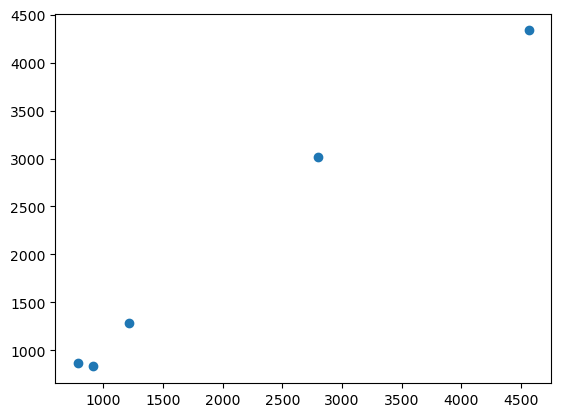

In [14]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(preprocessing_results_obj['training']['predictions']['MomentsLD_t_split'], preprocessing_results_obj['training']['targets']['simulated_params_t_split'])
plt.show()

In [15]:
training_features = np.load('/sietch_colab/akapoor/Demographic_Inference/split_isolation_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/sims/sims_pretrain_10_sims_inference_1_seed_42_num_replicates_3_top_values_2/training_features.npy')

In [16]:
training_features.shape

(5, 45)

In [17]:
with open('/sietch_colab/akapoor/Demographic_Inference/split_isolation_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/sims/sims_pretrain_10_sims_inference_1_seed_42_num_replicates_3_top_values_2/postprocessing_results.pkl', 'rb') as f:
    postprocessing_results = pickle.load(f)

In [20]:
postprocessing_results['training']['predictions'].shape

(5, 45)

In [1]:
import pickle
with open('/sietch_colab/akapoor/Demographic_Inference/split_isolation_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/sims/sims_pretrain_100_sims_inference_1_seed_42_num_replicates_3_top_values_2/features_and_targets.pkl', 'rb') as f:
    features_and_targets = pickle.load(f)

In [12]:
import numpy as np
np.min(features_and_targets['training']['targets'])

-5.136223464764749

In [13]:
with open('/sietch_colab/akapoor/Demographic_Inference/split_isolation_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/models/sims_pretrain_100_sims_inference_1_seed_42_num_replicates_3_top_values_2/num_hidden_neurons_1000_num_hidden_layers_3_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_35_EarlyStopping_False/linear_mdl_obj.pkl', 'rb') as f:
    linear_mdl_obj = pickle.load(f)

In [25]:
linear_mdl_obj['param_names']

['Na', 'N1', 'N2', 't_split', 'm']

In [21]:
np.max(linear_mdl_obj['training']['targets'])

12.313113843031482

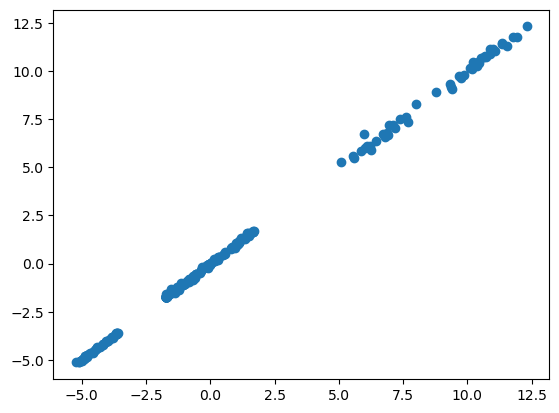

In [24]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(linear_mdl_obj['training']['predictions'], linear_mdl_obj['training']['targets'])

In [26]:
import math
def visualizing_results(
    linear_mdl_obj, analysis, save_loc="results", outlier_indices=None, stages=None, color_shades=None, main_colors=None
):
    # Default to all stages if not specified
    if stages is None:
        stages = ["training", "validation", "testing"]

    params = linear_mdl_obj['param_names']
    num_params = len(params)

    rows = math.ceil(math.sqrt(num_params))
    cols = math.ceil(num_params / rows)

    plt.figure(figsize=(5 * cols, 5 * rows))

    # Loop through each parameter (dimension of the parameters)
    for i, param in enumerate(params):
        plt.subplot(rows, cols, i + 1)

        all_predictions = []
        all_targets = []

        # Loop through each stage and parameter combination
        for j, stage in enumerate(stages):
            predictions = linear_mdl_obj[stage]["predictions"][:, i]  # Only for the current parameter
            targets = linear_mdl_obj[stage]["targets"][:, i]  # Only for the current parameter

            # Append current parameter's predictions and targets to global lists for axis scaling
            all_predictions.extend(predictions)
            all_targets.extend(targets)

            # Scatter plot for each stage
            plt.scatter(
                targets,
                predictions,
                alpha=0.5,
                color=color_shades[main_colors[i % len(main_colors)]][j],  # Color for each stage #type:ignore 
                label=f"{stage.capitalize()}",
            )

        # Set equal axis limits based on global min/max for each parameter's predictions and targets
        max_value = max(max(all_predictions), max(all_targets))
        min_value = min(min(all_predictions), min(all_targets))
        
        plt.xlim([min_value, max_value])
        plt.ylim([min_value, max_value])

        # Add the ideal line y = x
        plt.plot(
            [min_value, max_value],
            [min_value, max_value],
            color="black",
            linestyle="--",
            label="Ideal: Prediction = Target",
        )

        # Set equal aspect ratio
        plt.gca().set_aspect('equal', 'box')

        # Labels and title
        plt.xlabel(f"True {param}")
        plt.ylabel(f"Predicted {param}")
        plt.title(f"{param}: True vs Predicted")

        plt.legend()

    plt.tight_layout()

    # Save the figure
    filename = f"{save_loc}/{analysis}"
    if outlier_indices is not None:
        filename += "_outliers_removed"
    filename += ".png"

    plt.savefig(filename, format="png", dpi=300)
    plt.show()


In [32]:
predictions = linear_mdl_obj['training']["predictions"][:, 0]  # Only for the current parameter
predictions

array([-4.30887479, -3.80116554, -5.00427581, -5.11066011, -4.92136017,
       -4.56816123, -5.00143907, -4.92840327, -3.65002839, -4.43540923,
       -3.80754523, -3.68308754, -4.87482768, -4.88077574, -3.62904959,
       -4.92092692, -3.65964698, -4.17554127, -4.86796269, -4.18309539,
       -4.73557953, -5.06241778, -3.66370302, -4.47596481, -5.22506507,
       -4.17365208, -3.62913206, -3.9776578 , -4.66558071, -4.06735213,
       -4.9891691 , -4.38956203, -4.05879454, -4.43261851, -4.87003348,
       -3.82585208, -3.58391169, -4.80156821, -4.78027336, -4.55283218,
       -5.11227351, -4.88546271, -3.88957259, -4.40757645, -4.02328079,
       -3.70165689, -4.52999589, -4.33584107, -4.97166496, -4.98794029])

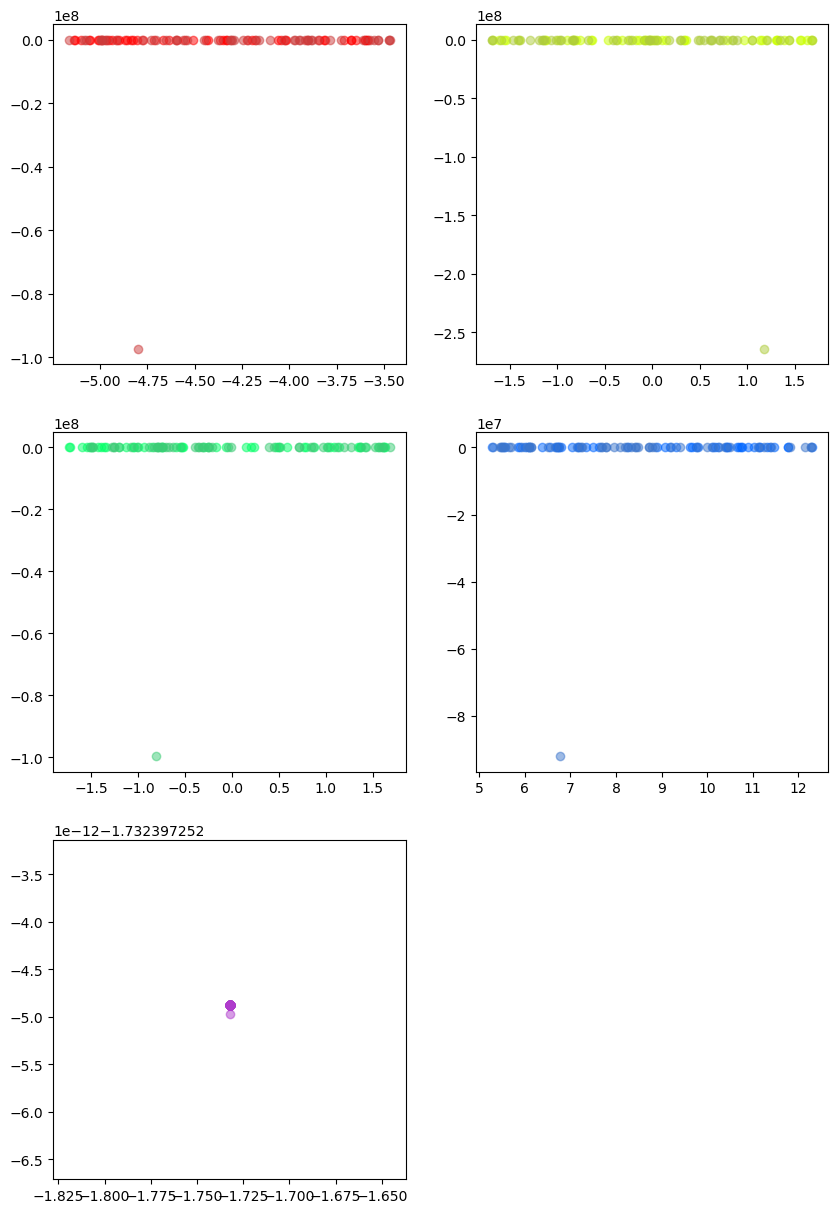

In [35]:
params = linear_mdl_obj['param_names']
num_params = len(params)
stages = ['training', 'validation']

with open('/sietch_colab/akapoor/Demographic_Inference/split_isolation_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/sims/sims_pretrain_100_sims_inference_1_seed_42_num_replicates_3_top_values_2/color_shades.pkl', 'rb') as f:
    color_shades = pickle.load(f)

with open('/sietch_colab/akapoor/Demographic_Inference/split_isolation_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/sims/sims_pretrain_100_sims_inference_1_seed_42_num_replicates_3_top_values_2/main_colors.pkl', 'rb') as f:
    main_colors = pickle.load(f)

rows = math.ceil(math.sqrt(num_params))
cols = math.ceil(num_params / rows)

plt.figure(figsize=(5 * cols, 5 * rows))

# Loop through each parameter (dimension of the parameters)
for i, param in enumerate(params):
    plt.subplot(rows, cols, i + 1)

    all_predictions = []
    all_targets = []

    # Loop through each stage and parameter combination
    for j, stage in enumerate(stages):
        predictions = linear_mdl_obj[stage]["predictions"][:, i]  # Only for the current parameter
        targets = linear_mdl_obj[stage]["targets"][:, i]  # Only for the current parameter

        # Append current parameter's predictions and targets to global lists for axis scaling
        all_predictions.extend(predictions)
        all_targets.extend(targets)

        # Scatter plot for each stage
        plt.scatter(
            targets,
            predictions,
            alpha=0.5,
            color=color_shades[main_colors[i % len(main_colors)]][j],  # Color for each stage #type:ignore 
            label=f"{stage.capitalize()}",
        )

In [39]:
np.min(linear_mdl_obj['validation']['predictions'])

-263708975.23521128

Comparing MomentsLD predictions to Neural Net Predictions

In [40]:
with open('/sietch_colab/akapoor/Demographic_Inference/split_isolation_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/sims/sims_pretrain_100_sims_inference_1_seed_42_num_replicates_3_top_values_2/preprocessing_results_obj.pkl', 'rb') as f:
    preprocessing_results_obj = pickle.load(f)

In [44]:
preprocessing_results_obj['training']['predictions'].columns

Index(['Moments_rep1_Na', 'Moments_rep1_N1', 'Moments_rep1_N2',
       'Moments_rep1_t_split', 'Moments_rep1_m', 'Moments_rep1_FIM_element_0',
       'Moments_rep1_FIM_element_1', 'Moments_rep1_FIM_element_2',
       'Moments_rep1_FIM_element_3', 'Moments_rep1_FIM_element_4',
       'Moments_rep1_FIM_element_5', 'Moments_rep1_FIM_element_6',
       'Moments_rep1_FIM_element_7', 'Moments_rep1_FIM_element_8',
       'Moments_rep1_FIM_element_9', 'Moments_rep2_Na', 'Moments_rep2_N1',
       'Moments_rep2_N2', 'Moments_rep2_t_split', 'Moments_rep2_m',
       'Moments_rep2_FIM_element_0', 'Moments_rep2_FIM_element_1',
       'Moments_rep2_FIM_element_2', 'Moments_rep2_FIM_element_3',
       'Moments_rep2_FIM_element_4', 'Moments_rep2_FIM_element_5',
       'Moments_rep2_FIM_element_6', 'Moments_rep2_FIM_element_7',
       'Moments_rep2_FIM_element_8', 'Moments_rep2_FIM_element_9',
       'MomentsLD_N1', 'MomentsLD_N2', 'MomentsLD_t_split', 'MomentsLD_m',
       'MomentsLD_Na', 'Dadi_rep1_Na

In [5]:
import pickle
with open('/sietch_colab/akapoor/Demographic_Inference/split_isolation_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/sims/sims_pretrain_100_sims_inference_1_seed_42_num_replicates_3_top_values_2/simulation_results/software_inferences_sim_42.pkl', 'rb') as f:
    software_inf = pickle.load(f)

In [7]:
software_inf

{'simulated_params': {'t_split': 1730,
  'N1': 7584,
  'N2': 9860,
  'Na': 11100,
  'm': 0},
 'sfs': Spectrum([[-- 492.00000000000006 164.0 157.0 54.0 30.0 9.0 13.0 12.0 0.0 6.0 0.0
   0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
  [360.0 42.0 38.0 16.0 11.0 15.0 8.0 5.0 5.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
   0.0 0.0 0.0 0.0 0.0]
  [116.0 32.0 14.0 51.0 16.0 5.0 21.0 9.0 15.0 3.0 3.0 0.0 2.0 0.0 0.0 0.0
   0.0 0.0 0.0 0.0 0.0]
  [80.0 9.0 6.0 18.0 8.0 7.0 8.0 2.0 14.0 6.0 0.0 0.0 0.0 0.0 0.0 0.0 3.0
   0.0 7.0 0.0 0.0]
  [65.0 10.0 6.0 16.0 5.0 4.0 2.0 29.0 14.0 6.0 1.0 8.0 0.0 1.0 0.0 1.0
   0.0 0.0 6.0 0.0 0.0]
  [37.0 5.0 13.0 3.0 13.0 0.0 2.0 1.0 1.0 0.0 0.0 6.0 6.0 0.0 0.0 0.0 9.0
   8.0 10.0 0.0 0.0]
  [65.0 13.0 6.0 15.0 12.0 5.0 11.0 12.0 13.0 4.0 6.0 0.0 10.0 2.0 3.0 1.0
   3.0 21.0 0.0 0.0 13.0]
  [5.0 13.0 0.0 16.0 26.0 1.0 3.0 5.0 13.0 8.0 8.0 8.0 3.0 0.0 7.0 1.0 0.0
   0.0 0.0 0.0 0.0]
  [7.0 2.0 1.0 3.0 17.0 12.0 9.0 0.0 5.0 6.0 7.0 7.0 0.0 0.0 7.0 7.0 0.0
   0.0 0.0 0.0 0.0]
  [8.0 

In [50]:
preprocessing_results_obj['training']['targets'].columns

Index(['simulated_params_t_split', 'simulated_params_N1',
       'simulated_params_N2', 'simulated_params_Na', 'simulated_params_m'],
      dtype='object')

In [47]:
from scipy.stats import spearmanr

Text(0.5, 1.0, "Spearman's rho: 0.9633")

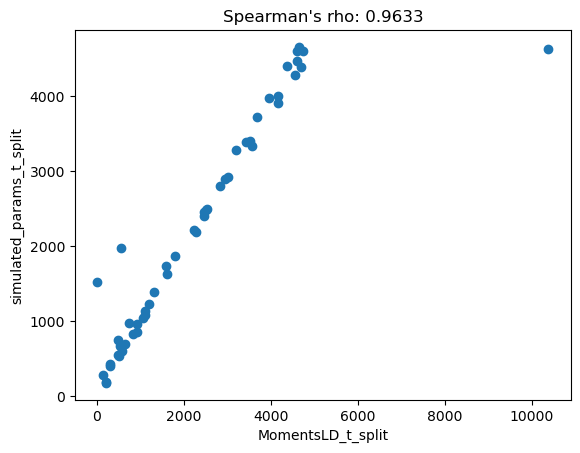

In [53]:
plt.figure()
plt.scatter(preprocessing_results_obj['training']['predictions']['MomentsLD_t_split'], preprocessing_results_obj['training']['targets']['simulated_params_t_split'])
plt.xlabel('MomentsLD_t_split')
plt.ylabel('simulated_params_t_split')
plt.title(f"Spearman's rho: {spearmanr(preprocessing_results_obj['training']['predictions']['MomentsLD_t_split'], preprocessing_results_obj['training']['targets']['simulated_params_t_split'])[0]:.4f}")

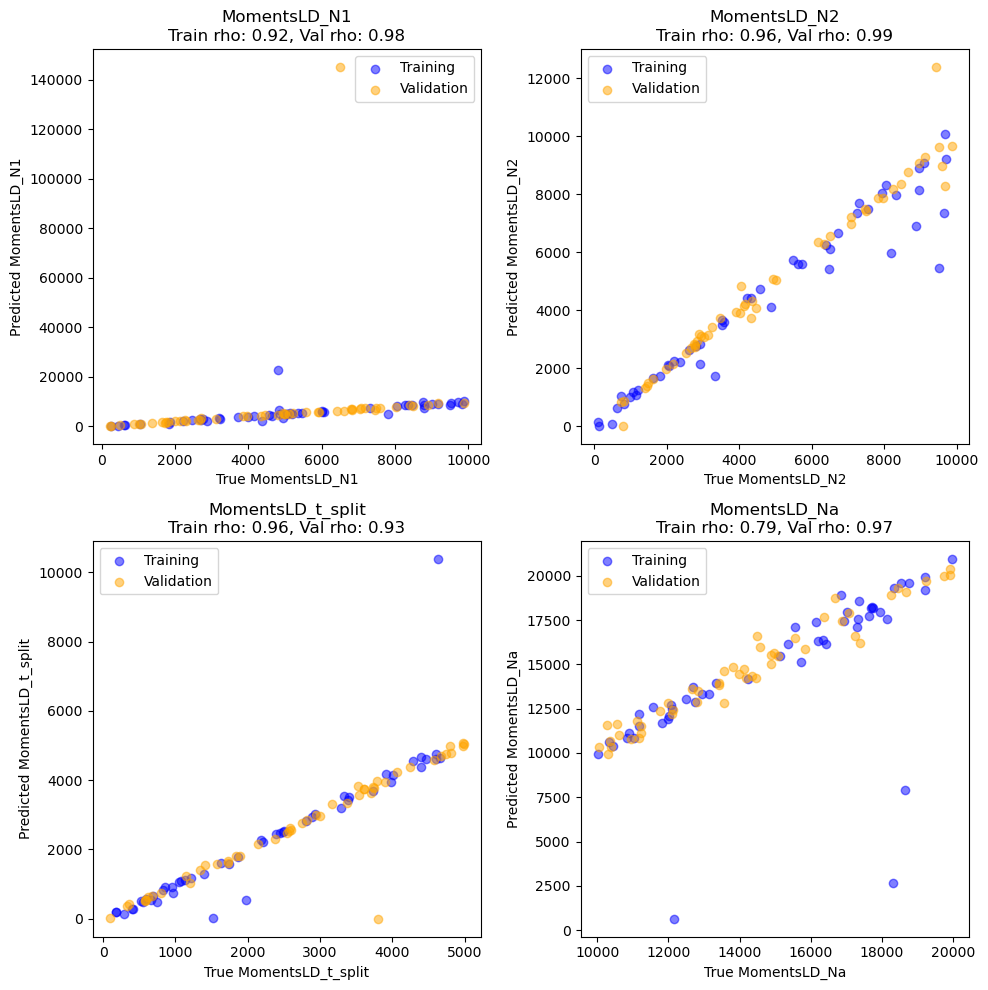

In [71]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import numpy as np

# List of parameters to plot
parameters = ['MomentsLD_N1', 'MomentsLD_N2', 'MomentsLD_t_split', 'MomentsLD_Na']

# Number of subplots (rows and columns)
n_params = len(parameters)
cols = 2  # Number of columns you want in your grid
rows = (n_params + cols - 1) // cols  # Calculate number of rows required

# Create a figure with subplots
plt.figure(figsize=(5 * cols, 5 * rows))

# Loop over the parameters and create scatter plots for training and validation for each
for i, param in enumerate(parameters):
    plt.subplot(rows, cols, i + 1)  # Create subplot
    
    # Training data
    train_predictions = preprocessing_results_obj['training']['predictions'][param]
    train_targets = preprocessing_results_obj['training']['targets'][f'simulated_params_{param.split("_", 1)[1]}']

    # Validation data
    val_predictions = preprocessing_results_obj['validation']['predictions'][param]
    val_targets = preprocessing_results_obj['validation']['targets'][f'simulated_params_{param.split("_", 1)[1]}']
    
    # Scatter plot for training data
    plt.scatter(train_targets, train_predictions, alpha=0.5, color='blue', label='Training')
    
    # Scatter plot for validation data
    plt.scatter(val_targets, val_predictions, alpha=0.5, color='orange', label='Validation')
    
    # Calculate Spearman's correlation for training and validation data
    train_rho, _ = spearmanr(train_predictions, train_targets)
    val_rho, _ = spearmanr(val_predictions, val_targets)
    
    # Labels and title
    plt.xlabel(f'True {param}')
    plt.ylabel(f'Predicted {param}')
    plt.title(f"{param}\nTrain rho: {train_rho:.2f}, Val rho: {val_rho:.2f}")
    
    # Add legend
    plt.legend()

# Adjust layout for the subplots
plt.tight_layout()
plt.show()



In [55]:
with open('/sietch_colab/akapoor/Demographic_Inference/split_isolation_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/models/sims_pretrain_100_sims_inference_1_seed_42_num_replicates_3_top_values_2/num_hidden_neurons_1000_num_hidden_layers_3_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_35_EarlyStopping_False/snn_results.pkl', 'rb') as f:
    snn_results = pickle.load(f)

In [60]:
snn_results['param_names']

['Na', 'N1', 'N2', 't_split', 'm']

In [62]:
snn_results['training']['targets'][:,0]

array([-4.33601599, -3.84134228, -5.05862759, -5.13449141, -4.90170379,
       -4.63323591, -5.01255504, -4.93703762, -3.64665977, -4.42781468,
       -3.81778639, -3.67367976, -4.8033233 , -4.86567713, -3.59954799,
       -4.95470454, -3.59054132, -4.2237791 , -4.85909534, -4.19433424,
       -4.71429589, -5.05135298, -3.6716013 , -4.51060671, -5.13622346,
       -4.18255629, -3.59885517, -4.02182198, -4.66787693, -4.05715581,
       -4.98969197, -4.36580727, -4.01835787, -4.43751417, -4.82480073,
       -3.80843332, -3.58118825, -4.83484662, -4.77318562, -4.59443797,
       -5.09811835, -4.90932481, -3.90404252, -4.33116625, -4.04156735,
       -3.71005283, -4.55079029, -4.34744753, -4.96717531, -5.00597324])

In [66]:
snn_results['param_names']

['Na', 'N1', 'N2', 't_split', 'm']

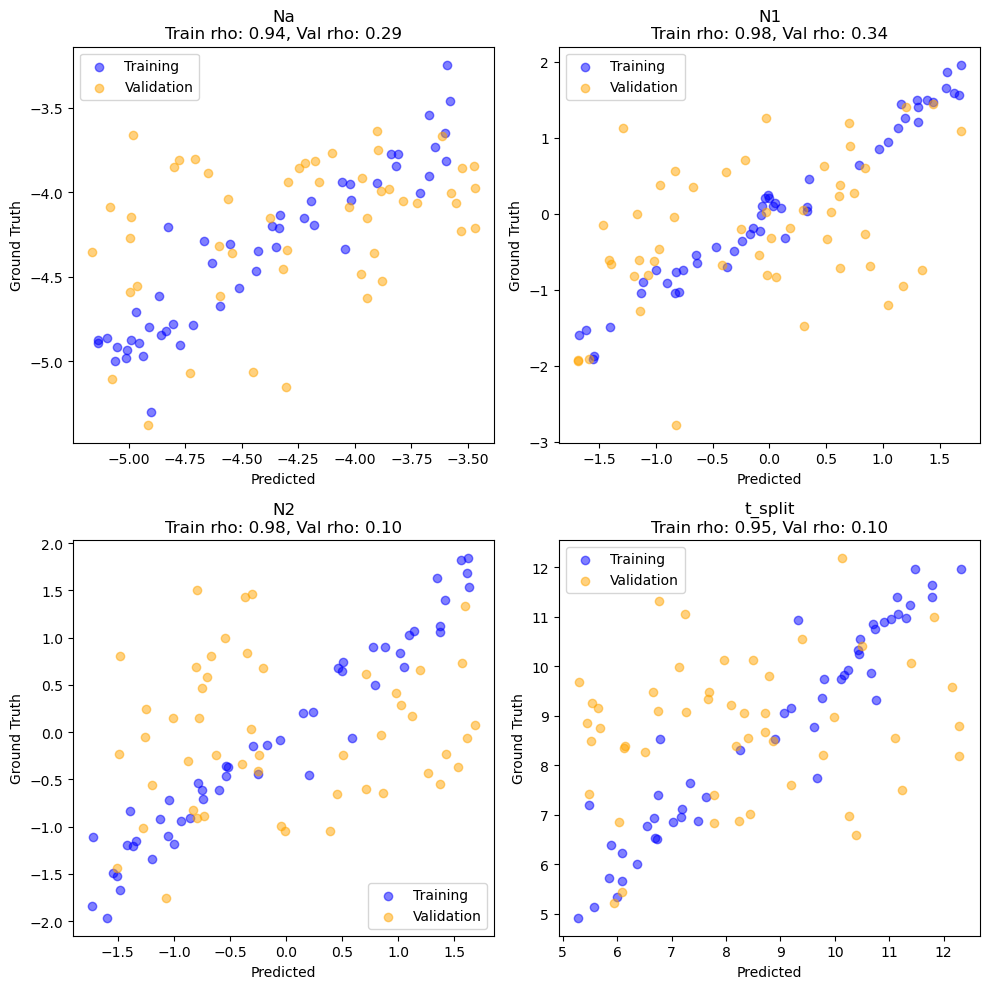

In [70]:
# List of parameters to plot
parameters = ['Na', 'N1', 'N2', 't_split']

# Number of subplots (rows and columns)
n_params = len(parameters)
cols = 2  # Number of columns you want in your grid
rows = (n_params + cols - 1) // cols  # Calculate number of rows required

# Create a figure with subplots
plt.figure(figsize=(5 * cols, 5 * rows))

# Loop over the parameters and create scatter plots for training and validation for each
for i, param in enumerate(parameters):
    plt.subplot(rows, cols, i + 1)  # Create subplot

    # Training data
    train_predictions = snn_results['training']['predictions'][:, i]
    train_targets = snn_results['training']['targets'][:, i]

    # Validation data
    val_predictions = snn_results['validation']['predictions'][:, i]
    val_targets = snn_results['validation']['targets'][:, i]
    
    # Scatter plot for training data
    plt.scatter(train_targets, train_predictions, alpha=0.5, color='blue', label='Training')
    
    # Scatter plot for validation data
    plt.scatter(val_targets, val_predictions, alpha=0.5, color='orange', label='Validation')
    
    # Calculate Spearman's correlation for training and validation data
    train_rho, _ = spearmanr(train_predictions, train_targets)
    val_rho, _ = spearmanr(val_predictions, val_targets)
    
    # Labels and title
    plt.xlabel(f'Predicted')
    plt.ylabel(f'Ground Truth')
    plt.title(f"{param}\nTrain rho: {train_rho:.2f}, Val rho: {val_rho:.2f}")
    
    # Add legend
    plt.legend()

# Adjust layout for the subplots
plt.tight_layout()
plt.show()